In [1]:
# %pip install numpy scipy scikit-learn matplotlib

In [2]:
import numpy as np
from sklearn.utils import murmurhash3_32

def lsh_knn(X_train, X_test, K, hash_bits=8, num_tables=5):
    # Initialize hash tables
    hash_tables = [{} for _ in range(num_tables)]
    
    def hash_function(point, num_bits):
        # Hash function using murmurhash3 and returns an integer hash for a vector
        return murmurhash3_32(point.tobytes()) & ((1 << num_bits) - 1)
    
    # Populate hash tables with the training data
    for idx, point in enumerate(X_train):
        for t in range(num_tables):
            h = hash_function(point, hash_bits)
            if h in hash_tables[t]:
                hash_tables[t][h].append(idx)
            else:
                hash_tables[t][h] = [idx]
    
    # Find K nearest neighbors using the LSH tables
    neighbors = []
    for point in X_test:
        # Gather candidate points from all tables
        candidates = set()
        for t in range(num_tables):
            h = hash_function(point, hash_bits)
            candidates.update(hash_tables[t].get(h, []))  # Add all candidate indices for this hash
        
        # Compute distances to candidates and select the closest K
        if candidates:
            candidate_points = X_train[list(candidates)]
            distances = np.sqrt(((candidate_points - point) ** 2).sum(axis=1))
            nearest_indices = np.argsort(distances)[:K]
            neighbors.append([list(candidates)[i] for i in nearest_indices])
        else:
            # If no candidates found, return empty list for this point
            neighbors.append([])

    return np.array(neighbors, dtype=object)  # Allow variable-length neighbor lists

# Example usage of lsh_knn function with randomly generated data
N = 200  # Number of points in the training set
D = 2    # Number of dimensions
K = 5    # Number of neighbors to find

# Generate random 2D dataset
X_train = np.random.rand(N, D)
X_test = np.random.rand(5, D)  # Small test set for visualization

# Run LSH KNN
neighbors = lsh_knn(X_train, X_test, K)
print("LSH Neighbors:", neighbors)


LSH Neighbors: [list([]) list([]) list([100, 49]) list([49, 100]) list([])]


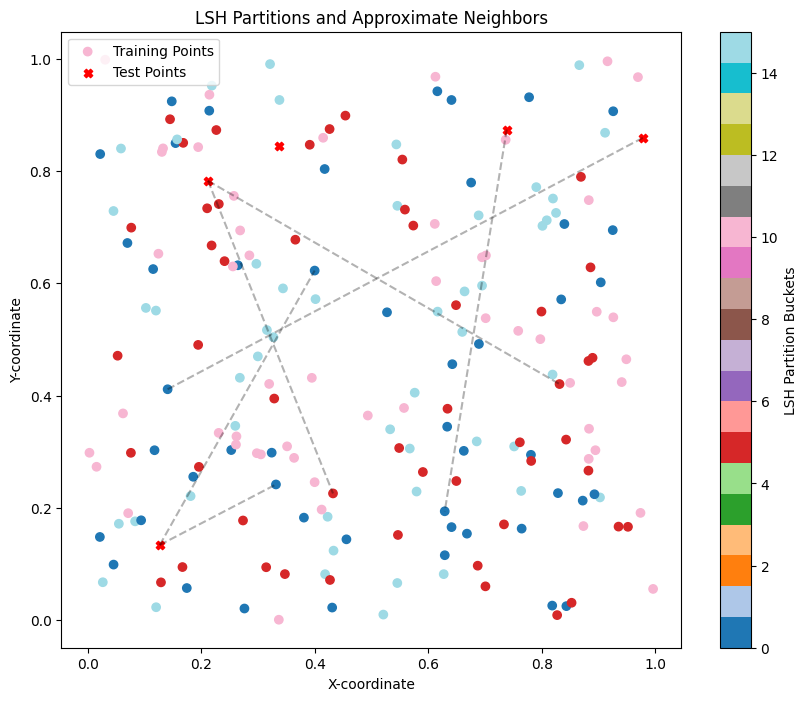

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import murmurhash3_32

def lsh_partition_2d(X_train, hash_bits=8, num_tables=5):
    # Initialize hash tables
    hash_tables = [{} for _ in range(num_tables)]
    
    def hash_function(point, num_bits):
        # Hash function using murmurhash3 and returns an integer hash for a vector
        return murmurhash3_32(point.tobytes()) & ((1 << num_bits) - 1)
    
    # Populate hash tables with the training data and assign each point a color based on hash value
    colors = []
    for idx, point in enumerate(X_train):
        hash_values = []
        for t in range(num_tables):
            h = hash_function(point, hash_bits)
            hash_values.append(h)
            if h not in hash_tables[t]:
                hash_tables[t][h] = []
            hash_tables[t][h].append(idx)
        
        # Combine hash values across tables to get a unique color for each bucket
        combined_hash = sum(hash_values)
        colors.append(combined_hash % 20)  # Limiting to 20 unique colors for visualization
    
    return colors

# Visualize the LSH partitions in 2D
def visualize_lsh_partitions(X_train, X_test, neighbors, colors):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_train[:, 0], X_train[:, 1], c=colors, cmap='tab20', label="Training Points")
    plt.scatter(X_test[:, 0], X_test[:, 1], c='red', marker='X', label="Test Points")

    # Draw lines connecting test points to their approximate neighbors
    for idx, test_point in enumerate(X_test):
        for neighbor_idx in neighbors[idx]:
            plt.plot([test_point[0], X_train[neighbor_idx, 0]], 
                     [test_point[1], X_train[neighbor_idx, 1]], 'k--', alpha=0.3)
    
    plt.colorbar(scatter, label="LSH Partition Buckets")
    plt.title("LSH Partitions and Approximate Neighbors")
    plt.xlabel("X-coordinate")
    plt.ylabel("Y-coordinate")
    plt.legend()
    plt.show()

# Parameters
N = 200  # Dataset size
D = 2    # Dimensions
K = 5    # Nearest neighbors
hash_bits = 8
num_tables = 5

# Generate dataset
X_train = np.random.rand(N, D)
X_test = np.random.rand(5, D)  # Small test set for visualization

# Run LSH KNN to get neighbors
neighbors = lsh_knn(X_train, X_test, K, hash_bits=hash_bits, num_tables=num_tables)

# Get partition colors
colors = lsh_partition_2d(X_train, hash_bits=hash_bits, num_tables=num_tables)

# Visualize the partitions and neighbors
visualize_lsh_partitions(X_train, X_test, neighbors, colors)


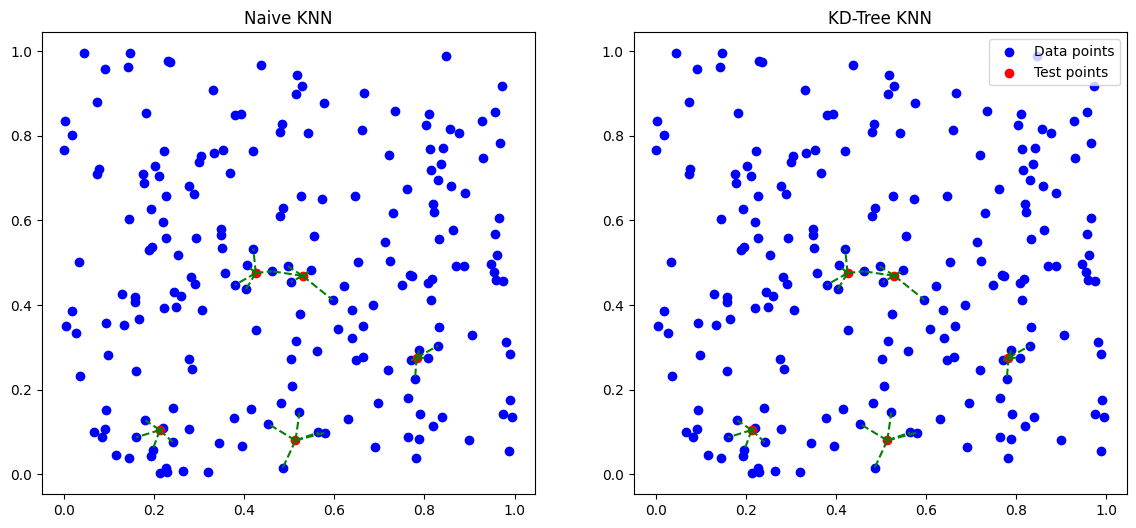

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KDTree
from sklearn.utils import murmurhash3_32
import time

# Generate random 2D dataset
def generate_data(N, D=2):
    return np.random.rand(N, D)

# Implement Naive KNN
def naive_knn(X_train, X_test, K):
    distances = np.sqrt(((X_train[:, None, :] - X_test[None, :, :]) ** 2).sum(axis=2))
    neighbors = np.argsort(distances, axis=0)[:K].T
    return neighbors

# Implement KD-tree KNN
def kd_tree_knn(X_train, X_test, K):
    tree = KDTree(X_train)
    distances, neighbors = tree.query(X_test, k=K)
    return neighbors


# Visualization of the comparison and partitions
def visualize_2d(X_train, X_test, K, methods):
    plt.figure(figsize=(14, 6))
    for i, (method_name, neighbors) in enumerate(methods):
        plt.subplot(1, len(methods), i + 1)
        plt.scatter(X_train[:, 0], X_train[:, 1], c='blue', label="Data points")
        plt.scatter(X_test[:, 0], X_test[:, 1], c='red', label="Test points")
        for idx, test_point in enumerate(X_test):
            for neighbor_idx in neighbors[idx]:
                plt.plot([test_point[0], X_train[neighbor_idx, 0]], [test_point[1], X_train[neighbor_idx, 1]], 'g--')
        plt.title(f"{method_name} KNN")
    plt.legend()
    plt.show()

# Parameters
N = 200  # Dataset size
D = 2    # Dimensions
K = 5    # Nearest neighbors

# Generate dataset
X_train = generate_data(N, D)
X_test = generate_data(5, D)  # Small test set for visualization

# Apply KNN variants
methods = [
    # ("LSH", lsh_knn(X_train, X_test, K)),
    ("Naive", naive_knn(X_train, X_test, K)),
    ("KD-Tree", kd_tree_knn(X_train, X_test, K)),
]

# Visualize the 2D partitions and missed neighbors
visualize_2d(X_train, X_test, K, methods)


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.utils import murmurhash3_32


# # Implement LSH KNN
# def lsh_knn(X_train, X_test, K, hash_bits=8, num_tables=5):
#     hash_tables = [{} for _ in range(num_tables)]
    
#     def hash_function(v, num_bits):
#         return murmurhash3_32(v.tobytes()) & ((1 << num_bits) - 1)
    
#     for i, point in enumerate(X_train):
#         for t in range(num_tables):
#             h = hash_function(point, hash_bits)
#             if h in hash_tables[t]:
#                 hash_tables[t][h].append(i)
#             else:
#                 hash_tables[t][h] = [i]
    
#     neighbors = []
#     for point in X_test:
#         candidates = set()
#         for t in range(num_tables):
#             h = hash_function(point, hash_bits)
#             candidates.update(hash_tables[t].get(h, []))
#         candidate_points = X_train[list(candidates)]
#         distances = np.sqrt(((candidate_points - point) ** 2).sum(axis=1))
#         nearest = np.argsort(distances)[:K]
#         neighbors.append(list(candidates)[nearest])
#     return np.array(neighbors)

# def lsh_partition_2d(X_train, hash_bits=8, num_tables=5):
#     # Initialize hash tables
#     hash_tables = [{} for _ in range(num_tables)]
    
#     def hash_function(point, num_bits):
#         # Hash function using murmurhash3 and returns an integer hash for a vector
#         return murmurhash3_32(point.tobytes()) & ((1 << num_bits) - 1)
    
#     # Populate hash tables with the training data and assign each point a color based on hash value
#     colors = []
#     for idx, point in enumerate(X_train):
#         hash_values = []
#         for t in range(num_tables):
#             h = hash_function(point, hash_bits)
#             hash_values.append(h)
#             if h not in hash_tables[t]:
#                 hash_tables[t][h] = []
#             hash_tables[t][h].append(idx)
        
#         # Combine hash values across tables to get a unique color for each bucket
#         combined_hash = sum(hash_values)
#         colors.append(combined_hash % 20)  # Limiting to 20 unique colors for visualization
    
#     return colors

# # Visualize the LSH partitions in 2D
# def visualize_lsh_partitions(X_train, X_test, neighbors, colors):
#     plt.figure(figsize=(10, 8))
#     scatter = plt.scatter(X_train[:, 0], X_train[:, 1], c=colors, cmap='tab20', label="Training Points")
#     plt.scatter(X_test[:, 0], X_test[:, 1], c='red', marker='X', label="Test Points")

#     # Draw lines connecting test points to their approximate neighbors
#     for idx, test_point in enumerate(X_test):
#         for neighbor_idx in neighbors[idx]:
#             plt.plot([test_point[0], X_train[neighbor_idx, 0]], 
#                      [test_point[1], X_train[neighbor_idx, 1]], 'k--', alpha=0.3)
    
#     plt.colorbar(scatter, label="LSH Partition Buckets")
#     plt.title("LSH Partitions and Approximate Neighbors")
#     plt.xlabel("X-coordinate")
#     plt.ylabel("Y-coordinate")
#     plt.legend()
#     plt.show()

# # Parameters
# N = 200  # Dataset size
# D = 2    # Dimensions
# K = 5    # Nearest neighbors
# hash_bits = 8
# num_tables = 5

# # Generate dataset
# X_train = np.random.rand(N, D)
# X_test = np.random.rand(5, D)  # Small test set for visualization

# # Run LSH KNN to get neighbors
# neighbors = lsh_knn(X_train, X_test, K, hash_bits=hash_bits, num_tables=num_tables)

# # Get partition colors
# colors = lsh_partition_2d(X_train, hash_bits=hash_bits, num_tables=num_tables)

# # Visualize the partitions and neighbors
# visualize_lsh_partitions(X_train, X_test, neighbors, colors)
